In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import transform

In [2]:
osm_data = pd.read_json('data/preprocessed-osm-data.json.gz')

raw_wikidata = pd.read_json('data/wikidata.json')
preprocessed_wikidata = pd.read_json('data/preprocessed-wikidata.json')
wikidata = raw_wikidata.merge(preprocessed_wikidata, on='qid')

wikidata['name'] = wikidata['names'].apply(lambda names: names[0])
descriptions = wikidata['preprocessed_description']

The aim of this notebook is to identify chain restaurants by determining which Wikidata entries are about chain restaurants and mapping the results back to the OSM data.

In [3]:
contains_chain = wikidata['preprocessed_description'].apply(
    lambda description: transform.get_match('chain', description)
).notna()
contains_restaurant = wikidata['preprocessed_description'].apply(
    lambda description: transform.get_match('restaurant', description)
).notna()

contains_chain_and_restaurant = (contains_chain & contains_restaurant)
chain_restaurant_wikidata = wikidata[contains_chain_and_restaurant]

First, we start off with a regex approach which assumes that a Wikidata entry is about a chain restaurant if its description contains both the words 'chain' and 'restaurant'. 

We check for both 'chain' and 'restaurant' based on how checking for 'chain' alone can potentially result in more false positives since it can also describe non-restaurants.

In [4]:
# include entries that contain the words 'chain' and 'restaurant'
chain_restaurant_wikidata = wikidata[contains_chain_and_restaurant]

# dict with (qid, 1) key value pairs for chain restaurant qids
chain_restaurant_qids = transform.get_chain_restaurant_qids(chain_restaurant_wikidata)

# map back to OSM data to get the number of chain restaurants
num_chain_restaurants = transform.get_num_chain_restaurants(osm_data, chain_restaurant_qids)

In [5]:
num_chain_restaurant_qids = len(chain_restaurant_qids)
print('Number of Wikidata Entries about Chain Restaurants: ', end='')
print(num_chain_restaurant_qids)
print(f'Number of Chain Restaurants: {num_chain_restaurants}')

Number of Wikidata Entries about Chain Restaurants: 38
Number of Chain Restaurants: 691


The regex approach considers 38 Wikidata entries to be about chain restaurants and 691 OSM locations to be chain restaurants. 

Limitations of the regex approach include how it may result in false negatives and underestimate the number of chain restaurants due to how descriptions for some chain restaurants may not contain both the words 'chain' and 'restaurant'.

Based on these limitations we move on to a mixed approach which uses the chain restaurants identified with regex alongside clustering with cosine similarity.

In [6]:
# calculate cosine similarities between each Wikidata description
vectorizer = CountVectorizer(lowercase=False)
document_term_matrix = vectorizer.fit_transform(descriptions)
cosine_similarities = cosine_similarity(document_term_matrix)

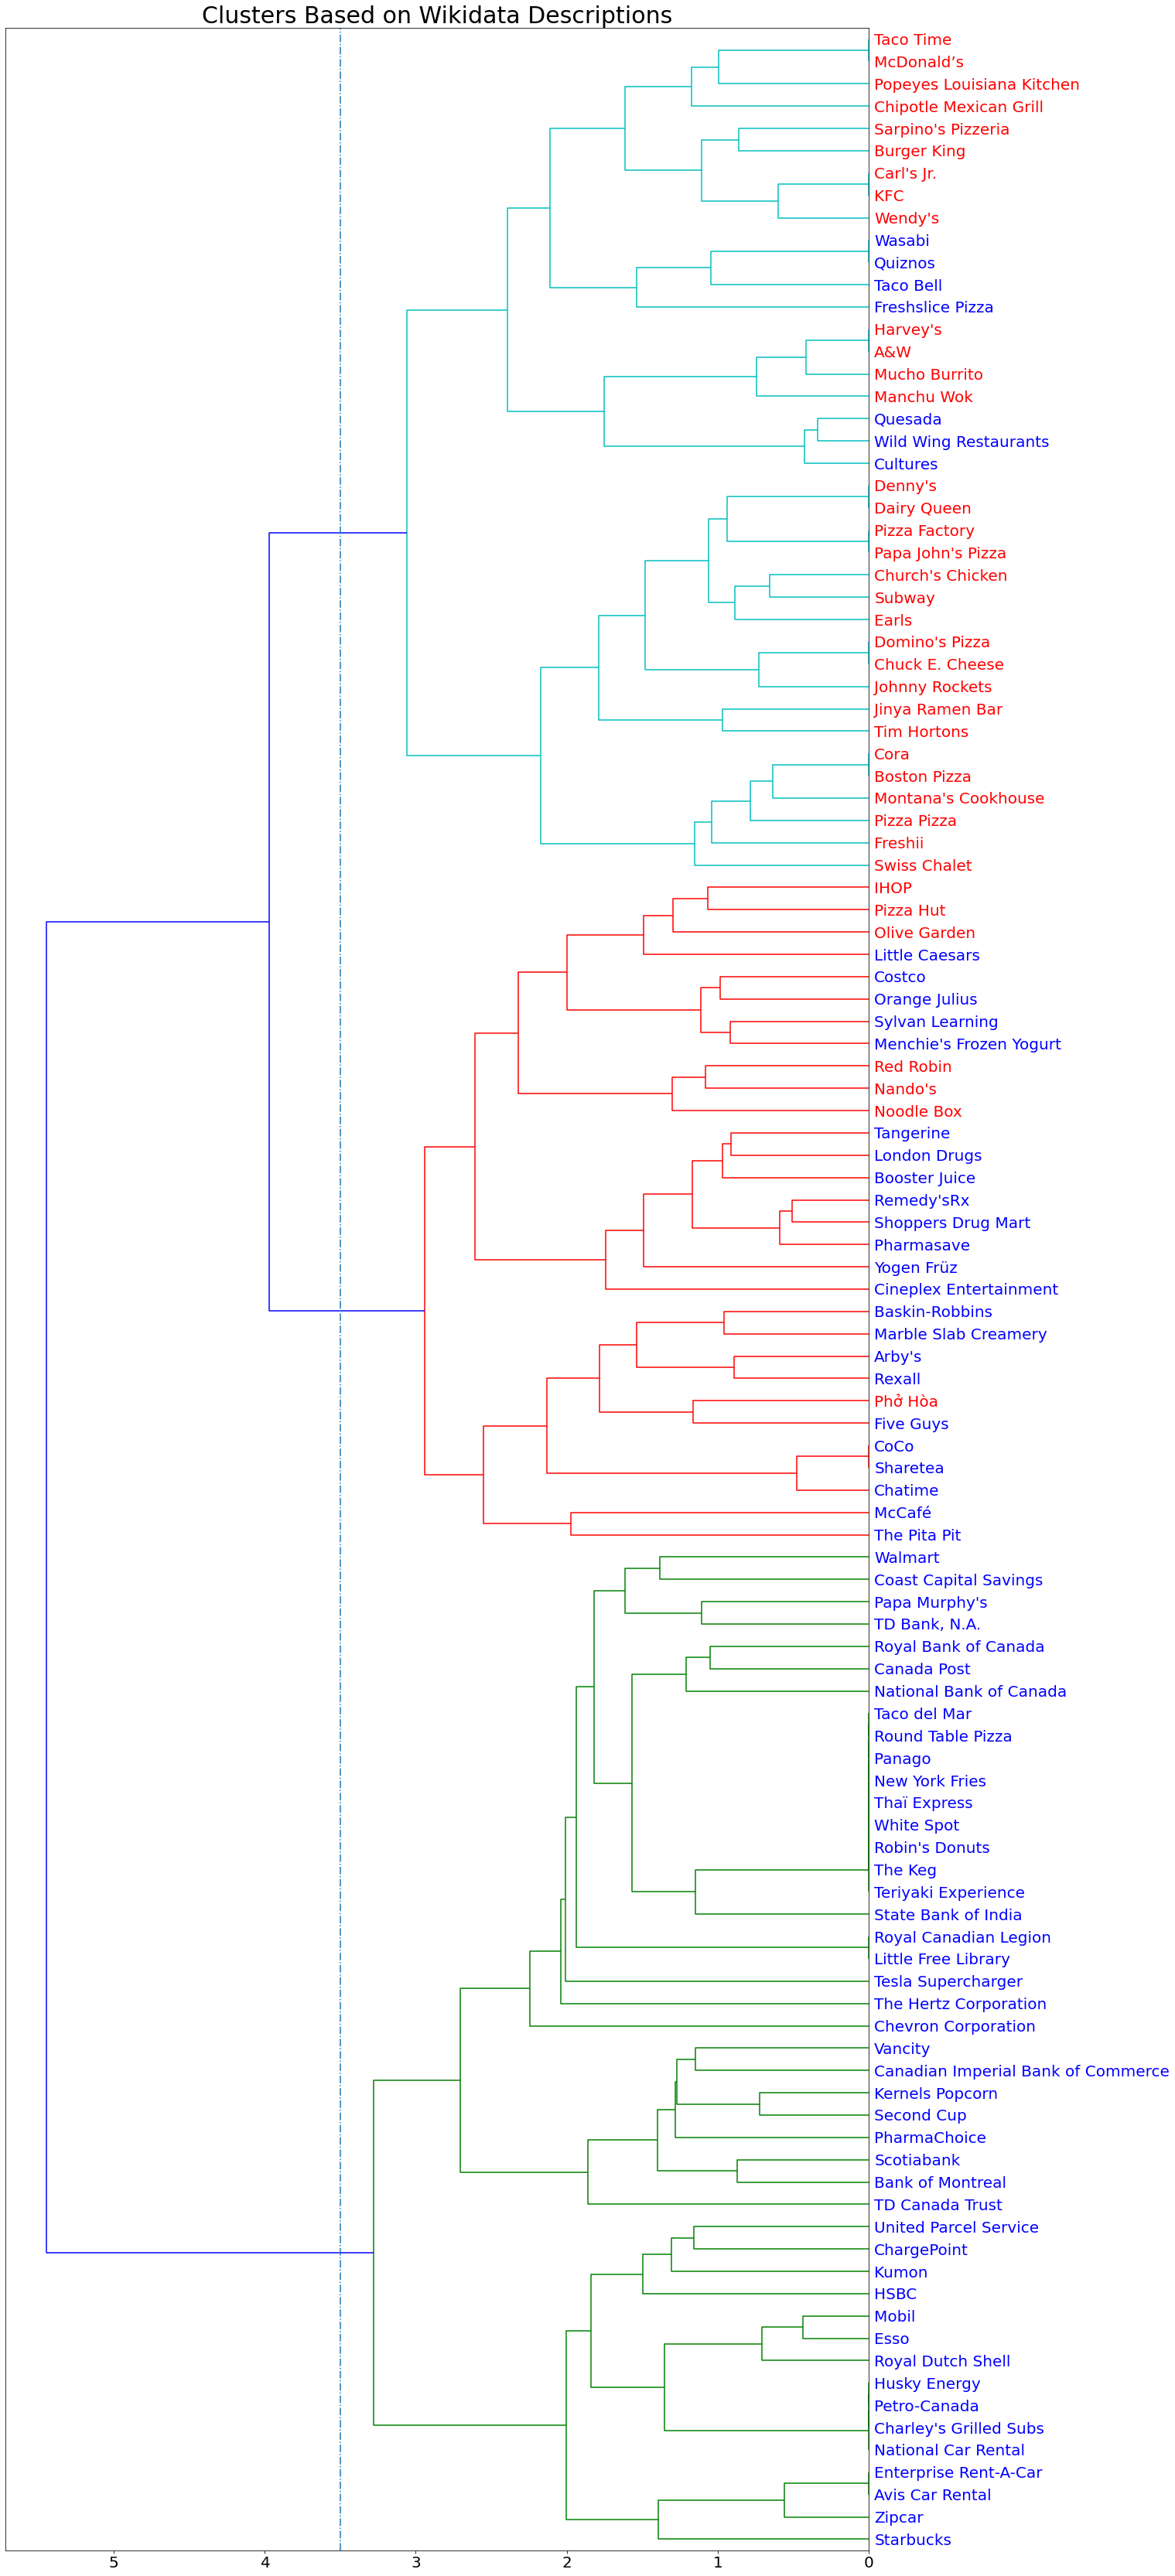

In [7]:
# get names for dendrogram labels 
chain_restaurant_names = chain_restaurant_wikidata['name'].values
names = wikidata['name']

# create dict with (name, color) key value pairs - names associated with chain 
# restaurants are mapped to red while other names are mapped to blue
color_dict = {
    name: ('r' if name in chain_restaurant_names else 'blue')
    for name in names
}
    
# Linkage and dendrogram code adapted from Scipy docs - does not render well on 
# gitlab, recommend running notebook or using a notebook viewer
Z = linkage(cosine_similarities, method='complete')
fig = plt.figure(figsize=(20, 60)) 
dn = dendrogram(
    Z, 
    leaf_label_func=lambda leaf_id: wikidata.loc[leaf_id, 'name'], 
    orientation='left', 
    leaf_font_size=20
) 

# label coloring adapted from Warren Weckesser's answer at 
# https://stackoverflow.com/questions/14802048/
ax = plt.gca()
y_tick_labels = ax.get_ymajorticklabels()
for y_tick_label in y_tick_labels:
    y_tick_label.set_color(color_dict[y_tick_label.get_text()])

plt.axvline(x=3.5, linestyle='-.')
plt.title('Clusters Based on Wikidata Descriptions', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Looking at the chain restaurants identified with regex (shown in red) we split the dendrogram into 3 clusters by cutting it at approximately x = 3.5 to combine as many chain restaurants as we can into a cluster while keeping chain restaurants separate from most other uncertain locations.

We then consider (blue) locations within the chain restaurant cluster (cluster with the most reds) to also be chain restaurants.

Limitations of this mixed approach include how it may also result in false negatives, underestimate the number of chain restaurants along with how it is not fully automatic due to how we must decide on number of clusters. A specific example of this can be seen at the very bottom where Starbucks has not been labeled as a chain restaurant and is significant as it can result in hundreds of mislabeled locations when the results are mapped back to the OSM data.

In [8]:
clusters = fcluster(Z, t=3, criterion='maxclust')

In [9]:
# create dataframe containing columns for name and cluster
name_cluster = pd.DataFrame.from_dict(
    dict(zip(names, clusters)), 
    orient='index'
).reset_index().rename(columns={'index': 'name', 0:'cluster'})

In [10]:
# find the cluster with the most chain restaurants 
chain_restaurant_wikidata = chain_restaurant_wikidata.merge(name_cluster, on='name')
chain_restaurant_cluster = chain_restaurant_wikidata['cluster'].value_counts().idxmax()

In [11]:
is_within_chain_restaurant_cluster = (name_cluster['cluster'] == chain_restaurant_cluster)
is_chain_restaurant = (contains_chain_and_restaurant | is_within_chain_restaurant_cluster)

In [12]:
# include entries within the cluster with the most chain restaurants 
updated_chain_restaurant_wikidata = wikidata[is_chain_restaurant]
updated_chain_restaurant_qids = transform.get_chain_restaurant_qids(updated_chain_restaurant_wikidata)

# map back to OSM data to get the updated number of chain restaurants
updated_num_chain_restaurants = transform.get_num_chain_restaurants(
    osm_data, 
    updated_chain_restaurant_qids
)

In [13]:
updated_num_chain_restaurant_qids = len(updated_chain_restaurant_qids)
print('Updated Number of Wikidata Entries about Chain Restaurants: ', end='')
print(updated_num_chain_restaurant_qids)
print(f'Updated Number of Chain Restaurants: {updated_num_chain_restaurants}')

Updated Number of Wikidata Entries about Chain Restaurants: 45
Updated Number of Chain Restaurants: 746


In [17]:
# combine number of chain restaurants / chain restaurant qids from regex and mixed approach
regex_approach_df = transform.num_to_long_df(
    num_chain_restaurant_qids, 
    num_chain_restaurants,
    'Regex'
)
mixed_approach_df = transform.num_to_long_df(
    updated_num_chain_restaurant_qids, 
    updated_num_chain_restaurants,
    'Mixed (Regex and Clustering)'
)
both_approach_df = pd.concat((regex_approach_df, mixed_approach_df))
both_approach_df.reset_index(drop=True, inplace=True)

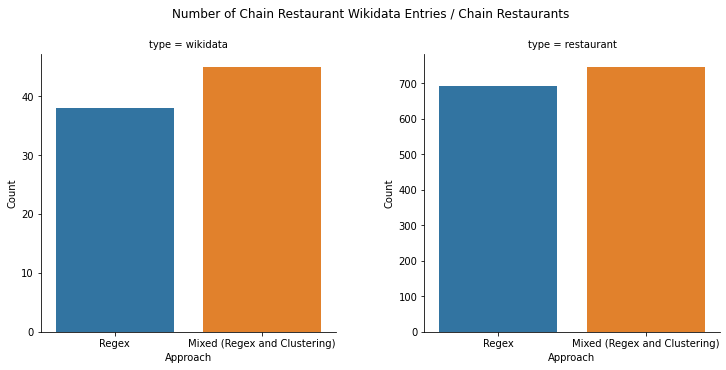

In [20]:
# visualize differences between regex and mixed approach
approach_plot = sns.catplot(
    data=both_approach_df, 
    x='approach', 
    y='value', 
    col='type', 
    kind='bar',
    sharey=False
)
approach_plot.set(
    xlabel='Approach', 
    ylabel='Count'
)
plt.suptitle('Number of Chain Restaurant Wikidata Entries / Chain Restaurants')
plt.subplots_adjust(wspace=0.3, top=0.85)
plt.show()

In [16]:
# convert to dataframe and write to json
final_chain_restaurant_qids = pd.DataFrame.from_dict(
    updated_chain_restaurant_qids, 
    orient='index'
)
final_chain_restaurant_qids.reset_index(inplace=True)
final_chain_restaurant_qids.rename(
    columns={'index': 'qid', 0:'is_chain_restaurant'},
    inplace=True
)
final_chain_restaurant_qids.to_json('data/chain-restaurant-qids.json')